In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download moon1570/isic-2017-train-val-test-images-and-masks -p /content --quiet


Dataset URL: https://www.kaggle.com/datasets/moon1570/isic-2017-train-val-test-images-and-masks
License(s): MIT
User cancelled operation
Exception ignored in: <module 'threading' from '/usr/lib/python3.12/threading.py'>
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1575, in _shutdown
    def _shutdown():
    
KeyboardInterrupt: 


In [5]:
!ls


'archive (23).zip'   kaggle.json   sample_data


In [6]:
!unzip "archive (23).zip"


Streaming output truncated to the last 5000 lines.
  inflating: data/data/images/2014.png  
  inflating: data/data/images/2015.png  
  inflating: data/data/images/2016.png  
  inflating: data/data/images/2017.png  
  inflating: data/data/images/2018.png  
  inflating: data/data/images/2019.png  
  inflating: data/data/images/202.png  
  inflating: data/data/images/2020.png  
  inflating: data/data/images/2021.png  
  inflating: data/data/images/2022.png  
  inflating: data/data/images/2023.png  
  inflating: data/data/images/2024.png  
  inflating: data/data/images/2025.png  
  inflating: data/data/images/2026.png  
  inflating: data/data/images/2027.png  
  inflating: data/data/images/2028.png  
  inflating: data/data/images/2029.png  
  inflating: data/data/images/203.png  
  inflating: data/data/images/2030.png  
  inflating: data/data/images/2031.png  
  inflating: data/data/images/2032.png  
  inflating: data/data/images/2033.png  
  inflating: data/data/images/2034.png  
  inflat

In [7]:
!ls data/data


images	masks


In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models


In [9]:
IMAGE_DIR = "data/data/images"
MASK_DIR  = "data/data/masks"
IMG_SIZE = 128


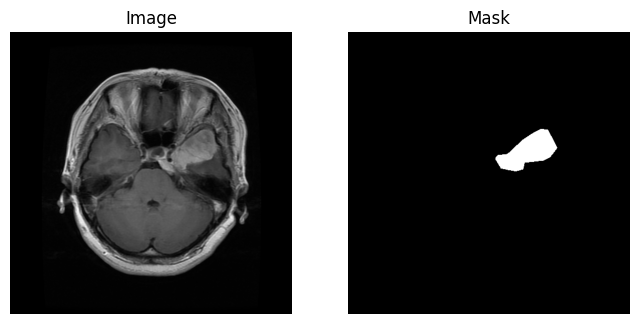

In [10]:
img_name = sorted(os.listdir(IMAGE_DIR))[0]

img = cv2.imread(os.path.join(IMAGE_DIR, img_name))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = cv2.imread(os.path.join(MASK_DIR, img_name), cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask, cmap="gray")
plt.title("Mask")
plt.axis("off")

plt.show()


In [11]:
def load_data(img_dir, mask_dir):
    images, masks = [], []
    files = sorted(os.listdir(img_dir))

    for f in files:
        img = cv2.imread(os.path.join(img_dir, f))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0

        mask = cv2.imread(os.path.join(mask_dir, f), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
        mask = (mask > 0).astype(np.float32)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)


In [12]:
X, Y = load_data(IMAGE_DIR, MASK_DIR)
Y = np.expand_dims(Y, axis=-1)

print(X.shape, Y.shape)


(3064, 128, 128, 3) (3064, 128, 128, 1)


In [13]:
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42
)


In [14]:
def build_unet(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    # Bottleneck
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(64, 3, activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(64, 3, activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(32, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(32, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(16, 2, strides=2, padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(16, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(16, 3, activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c7)

    return models.Model(inputs, outputs)


In [15]:
model = build_unet((IMG_SIZE, IMG_SIZE, 3))
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │     32,832 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │     73,792 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │      8,224 │ conv2d_9[0][0]  

 Total params: 482,033 (1.84 MB)

 Trainable params: 482,033 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=15,
    batch_size=16
)


Epoch 1/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 29s 85ms/step - accuracy: 0.9633 - loss: 0.2155 - val_accuracy: 0.9823 - val_loss: 0.0672
Epoch 2/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9828 - loss: 0.0639 - val_accuracy: 0.9823 - val_loss: 0.0615
Epoch 3/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9823 - loss: 0.0585 - val_accuracy: 0.9848 - val_loss: 0.0473
Epoch 4/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9854 - loss: 0.0455 - val_accuracy: 0.9873 - val_loss: 0.0392
Epoch 5/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9860 - loss: 0.0409 - val_accuracy: 0.9881 - val_loss: 0.0358
Epoch 6/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9874 - loss: 0.0367 - val_accuracy: 0.9876 - val_loss: 0.0362
Epoch 7/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9880 - loss: 0.0348 - val_accuracy: 0.9892 - val_loss: 0.0322
Epoch 8/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9889 - loss: 0.0306 - val_acc

In [18]:
preds = model.predict(X_val)
preds = (preds > 0.5).astype(np.uint8)


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step


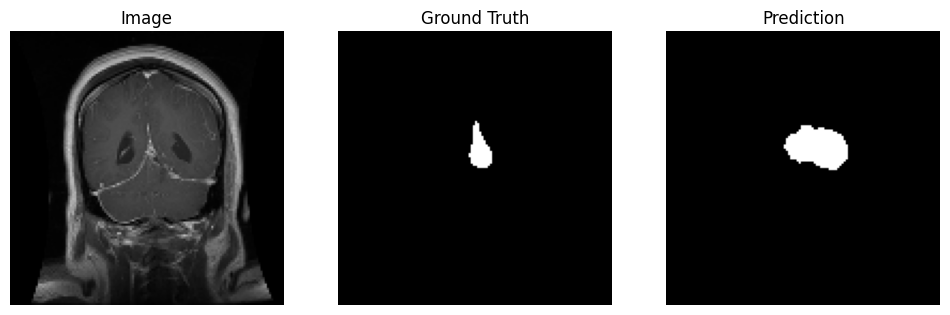

In [19]:
idx = 3
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(X_val[idx])
plt.title("Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(Y_val[idx].squeeze(), cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(preds[idx].squeeze(), cmap="gray")
plt.title("Prediction")
plt.axis("off")

plt.show()


In [20]:
def dice_coef(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-6)

def iou_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / (union + 1e-6)


In [21]:
dice_scores = []
iou_scores = []

for i in range(len(preds)):
    dice_scores.append(dice_coef(Y_val[i], preds[i]))
    iou_scores.append(iou_score(Y_val[i], preds[i]))

print("Mean Dice:", np.mean(dice_scores))
print("Mean IoU:", np.mean(iou_scores))


Mean Dice: 0.7068489346825554
Mean IoU: 0.6147578376663018


In [22]:
area = np.sum(mask)


In [23]:
contours, _ = cv2.findContours(
    mask.astype(np.uint8),
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE
)

largest_contour = max(contours, key=cv2.contourArea)
perimeter = cv2.arcLength(largest_contour, closed=True)


In [24]:
compactness = (4 * np.pi * area) / (perimeter ** 2 + 1e-6)


In [28]:
def extract_morphological_features(mask, min_area=10):
    mask = mask.squeeze().astype(np.uint8)

    area = np.sum(mask)

    # Ignore empty / tiny predictions
    if area < min_area:
        return None, None, None

    contours, _ = cv2.findContours(
        mask,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    if len(contours) == 0:
        return None, None, None

    cnt = max(contours, key=cv2.contourArea)
    perimeter = cv2.arcLength(cnt, True)

    if perimeter < 1e-3:
        return None, None, None

    compactness = (4 * np.pi * area) / (perimeter ** 2)

    return area, perimeter, compactness


In [29]:
areas, perimeters, compactnesses = [], [], []

for i in range(len(preds)):
    a, p, c = extract_morphological_features(preds[i])

    if a is None:
        continue

    areas.append(a)
    perimeters.append(p)
    compactnesses.append(c)

print("Valid samples:", len(areas))
print("Mean Area:", np.mean(areas))
print("Mean Compactness:", np.mean(compactnesses))


Valid samples: 566
Mean Area: 267.87632508833923
Mean Compactness: 0.8770099765358823
